In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [1]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
import itertools
from librosa import display
warnings.filterwarnings('ignore')

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list

def pitch_trans(seq):
    pitch_list = ['C','C#','D','D#(E-)','E','F','F#','G','G#','A','A#(B-)','B']
    return pitch_list[seq]

def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]


## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [24]:
## Analysis chord and pitch4
def n_gram(key_list, ngram):
    ngram_key = []
    flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(flattened)-3)):
        ngram_key.append(flattened[i : ngram +i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

def n_gram2(key_list, ngram):
    ngram_key = []
#     flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(key_list)-3)):
        ngram_key.append(key_list[i : ngram+i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

## Get Chord (4 beats)

In [88]:
## get all file name
sleeping_music = sorted(get_dirs('./music/sleeping'))
print(len(sleeping_music))

75


In [57]:
sleeping_music[0]

'1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav'

In [114]:
sleeping_key = []; pitch = []
def job(num1, num2):
#     for idx in range(len(sleeping_music)):
    for idx in range(num1, num2):
        temp2 = []; temp3 = []
        for i in range(300):
            try:
                y1, sr = librosa.load('./music/sleeping/'+ sleeping_music[idx],offset=4*i,duration = 4, res_type = "kaiser_fast")
                ## onset detection
                o_env = librosa.onset.onset_strength(y1, sr=sr)
                onset_frames = librosa.onset.onset_detect(y=y1, onset_envelope=o_env, sr=sr)

                ## pitch detection
                b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=512)

                temp =[]
                for i in range(len(onset_frames)): 
                    temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
                for i in range(len(temp)):
                    temp3.append(pitch_trans(temp[i]))    

                ## count CE
                CE = (count_CE(temp))
                temp2.append(get_key(CE, pitch_ary))
            except:
                pass
        sleeping_key.append(temp2)
        pitch.append(temp3)
        print("Finish", idx)

In [115]:
import threading
import time

## multi thread

threads = []; threads2 = []; threads3 = []; threads4 = []

threads.append(threading.Thread(target = job, args = (0,19))) 
for t in threads:
    t.start()
    
threads2.append(threading.Thread(target = job, args = (19,38))) 
for t2 in threads2:
    t2.start()
    
threads3.append(threading.Thread(target = job, args = (38,58))) 
for t2 in threads3:
    t2.start()
    
threads4.append(threading.Thread(target = job, args = (58,75))) 
for t2 in threads4:
    t2.start()

In [118]:
len(sleeping_key)

75

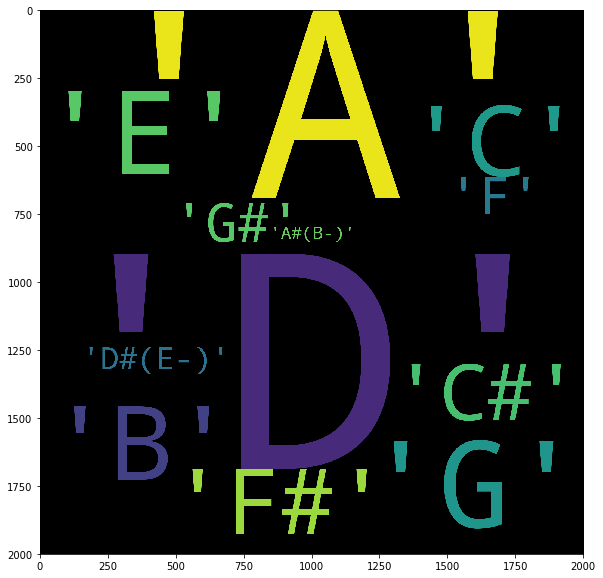

In [119]:
a = n_gram(sleeping_key,1)
plot_wordcloud(a,30)

## Analysis - Chord

In [107]:
## pitch matching

perfect_five = [['C','G'],['G','D'],['D','A'],['A','E'],['E','B'],['B','F#'],['F#','C#'],['C#','G#'],
                ['G#','D#(E-)'],['D#(E-)','A#(B-)'],['A#(B-)','F'],['F','C']]

same_pitch2 = [['C','C','C'],['D','D','D'],['A','A','A'],['E','E','E'],['B','B','B'],['F#','F#','F#'],
              ['C#','C#','C#'],['G#','G#','G#'], ['D#(E-)','D#(E-)','D#(E-)'],
              ['A#(B-)','A#(B-)','A#(B-)'],['F','F','F'],['G','G','G']]

same_pitch = [['C','C'],['D','D'],['A','A'],['E','E'],['B','B'],['F#','F#'],['C#','C#'],
              ['G#','G#'], ['D#(E-)','D#(E-)'],['A#(B-)','A#(B-)'],['F','F'],['G','G']]

big_three = [['C','E'],['D','F#'],['E','G#'],['F','A'],['G','B'],['A','C#'],['B','D#'],
             ['C#','F'],['D#(E-)','G'],['F#','A#(B-)'],['G#','C'],['A#','D']]

small_three = [['C','D#'],['D','F'],['E','G'],['F','G#'],['G','A#'],['A','C'],['B','D'],
             ['C#','E'],['D#(E-)','F#'],['F#','A'],['G#','B'],['A#','C#']]

four_pitch = [['C','F'],['D','G'],['E','A'],['F','A#(B-)'],['G','C'],['A','D'],['B','E'],
             ['C#','F#'],['D#(E-)','G#'],['F#','B'],['G#','C#'],['A#','D#(E-)']]

whole_tone = [['C','D'],['D','E'],['E','F#'],['F','G'],['G','A'],['A','B'],['B','C#'],
             ['C#','D#(E-)'],['D#(E-)','F'],['F#','G#'],['G#','A#'],['A#','C'],
             ['D','C'],['E','D'],['F#','E'],['G','F'],['A','G'],['B','A'],['C#','B'],
             ['D#(E-)','C#'],['F','D#(E-)'],['G#','F#'],['A#','G#'],['C','A#']]

### Chord progression in all dataset

In [120]:
perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0; four = 0; whole = 0
perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0; four_= 0; whole_ = 0
## flatteren
flattened = [val for sublist in sleeping_key for val in sublist]
for i in range(len(flattened)-2):
    if flattened[i:i+2] in perfect_five:
        perfect = perfect+1
    elif flattened[i:i+2] in big_three:
        big3 = big3+1
    elif flattened[i:i+2] in small_three:
        small3 = small3+1
    elif flattened[i:i+2] in same_pitch:
        same = same+1
    elif flattened[i:i+2] in four_pitch:
        four = four+1
    elif flattened[i:i+2] in whole_tone:
        whole = whole+1
    else:
        non = non+1

    try:
        perfect_ = round(perfect/len(flattened) *100,2)
        same_ = round(same/len(flattened) *100,2)
        non_ = round(non/len(flattened) *100,2)
        big3_ = round(big3/len(flattened) *100,2)
        small3_ = round(small3/len(flattened) *100,2)
        four_ = round(four/len(flattened) *100,2)
        whole_ = round(whole/len(flattened) *100,2)
    except:
        pass
    
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')

Perfect 5: 20.07 %
Big three: 1.4 %
Small 3.48 %
Stable: 30.16 %
Four: 19.52 %
WholeTone: 17.32 %
Other 8.03 %


### Chord progression in each songs

In [121]:
for idx in range(len(sleeping_music)):
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0; four = 0; whole = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0; four_= 0; whole_ = 0
    for i in range(len(sleeping_key[idx])-2):
        if sleeping_key[idx][i:i+2] in perfect_five:
            perfect = perfect+1
        elif sleeping_key[idx][i:i+2] in big_three:
            big3 = big3+1
        elif sleeping_key[idx][i:i+2] in small_three:
            small3 = small3+1
        elif sleeping_key[idx][i:i+2] in same_pitch:
            same = same+1
        elif sleeping_key[idx][i:i+2] in four_pitch:
            four = four+1
        elif sleeping_key[idx][i:i+2] in whole_tone:
            whole = whole+1
        else:
            non = non+1

    try:
        perfect_ = round(perfect/len(sleeping_key[idx]) *100,2)
        same_ = round(same/len(sleeping_key[idx]) *100,2)
        non_ = round(non/len(sleeping_key[idx]) *100,2)
        big3_ = round(big3/len(sleeping_key[idx]) *100,2)
        small3_ = round(small3/len(sleeping_key[idx]) *100,2)
        four_ = round(four/len(sleeping_key[idx]) *100,2)
        whole_ = round(whole/len(sleeping_key[idx]) *100,2)
    except:
        pass
    
    print(idx,sleeping_music[idx])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Four:",four_, '%')
    print("WholeTone:",whole_, '%')
    print("Other",non_, '%')
    print()

0 1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav
Perfect 5: 19.33 %
Big three: 2.0 %
Small 4.33 %
Stable: 26.0 %
Four: 17.0 %
WholeTone: 17.0 %
Other 13.67 %

1 3小时放鬆的音樂  背景音樂  純音樂 輕快 水音  禪修音樂  輕音樂  心靈音樂.wav
Perfect 5: 22.33 %
Big three: 0.0 %
Small 5.0 %
Stable: 35.33 %
Four: 15.67 %
WholeTone: 19.67 %
Other 1.33 %

2 Relaxing Piano Music Sleep Music Water Sounds Relaxing Music Meditation Music ★47🍀.wav
Perfect 5: 20.67 %
Big three: 3.33 %
Small 4.0 %
Stable: 26.0 %
Four: 18.0 %
WholeTone: 20.33 %
Other 7.0 %

3 [無廣告版] 讀書工作好心情！放鬆舒壓鋼琴和大自然音律 - 5 HOURS RELAX STUDYING MUSIC FOR CONCENTRATION.wav
Perfect 5: 19.33 %
Big three: 2.33 %
Small 4.0 %
Stable: 27.0 %
Four: 19.67 %
WholeTone: 20.67 %
Other 6.33 %

4 m1.wav
Perfect 5: 21.56 %
Big three: 0.6 %
Small 1.2 %
Stable: 35.33 %
Four: 15.57 %
WholeTone: 19.16 %
Other 5.39 %

5 m10.wav
Perfect 5: 21.97 %
Big three: 1.73 %
Small 4.62 %
Stable: 32.95 %
Four: 21.97 %
WholeTone: 12.14 %
Other 3.47 %

6 m11.wav
Perfect 5: 23.0 %
Big three: 0.67 %

## Analysis - Pitch

### Find repeated pitch

In [93]:
## Check if it has a dominant key
## plot bar chart
for idx in range(len(sleeping_music)):
    print(idx, n_gram2(pitch[idx], 1))
    print()

0 {"'C'": 974, "'G'": 391, "'E'": 441, "'F'": 135, "'F#'": 28, "'D'": 77, "'A'": 82, "'B'": 53, "'D#(E-)'": 25, "'C#'": 44, "'A#(B-)'": 10}

1 {"'B'": 356, "'E'": 975, "'F#'": 225, "'A'": 281, "'G#'": 490, "'A#(B-)'": 30, "'F'": 203, "'G'": 297, "'C'": 266, "'D'": 91, "'C#'": 31, "'D#(E-)'": 80}

2 {"'F'": 27, "'C'": 24, "'F#'": 349, "'G#'": 287, "'G'": 18, "'E'": 871, "'B'": 701, "'A#(B-)'": 16, "'C#'": 353, "'D'": 142, "'A'": 356, "'D#(E-)'": 106}

3 {"'D'": 16, "'D#(E-)'": 678, "'F#'": 527, "'B'": 681, "'E'": 1556, "'A#(B-)'": 269, "'C'": 143, "'G'": 70, "'C#'": 521, "'G#'": 504, "'F'": 42, "'A'": 38}

4 {"'D#(E-)'": 457, "'F'": 435, "'C#'": 1060, "'G#'": 1330, "'C'": 223, "'D'": 24, "'E'": 22, "'G'": 19, "'A#(B-)'": 289, "'B'": 10, "'F#'": 423, "'A'": 32}

5 {"'C'": 991, "'C#'": 56, "'G'": 587, "'D'": 505, "'A'": 1069, "'A#(B-)'": 126, "'B'": 284, "'F'": 604, "'E'": 251, "'D#(E-)'": 206, "'G#'": 122, "'F#'": 34}

6 {"'C#'": 1775, "'G#'": 608, "'D#(E-)'": 153, "'A#(B-)'": 322, "'G'"

59 {"'D#(E-)'": 30, "'A'": 953, "'G'": 1048, "'D'": 870, "'B'": 241, "'G#'": 9, "'C#'": 19, "'C'": 165, "'E'": 429, "'F#'": 240, "'F'": 1, "'A#(B-)'": 13}



IndexError: list index out of range

Finish 73
Finish 15
Finish 53
Finish 34
Finish 74
Finish 16
Finish 54
Finish 35


### Pitch progression in all dataset

In [122]:
perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0; four = 0; whole = 0
perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0; four_= 0; whole_ = 0
## flatteren
flattened = [val for sublist in pitch for val in sublist]
for i in range(len(flattened)-2):
    if flattened[i:i+2] in perfect_five:
        perfect = perfect+1
    elif flattened[i:i+2] in big_three:
        big3 = big3+1
    elif flattened[i:i+2] in small_three:
        small3 = small3+1
    elif flattened[i:i+2] in same_pitch:
        same = same+1
    elif flattened[i:i+2] in four_pitch:
        four = four+1
    elif flattened[i:i+2] in whole_tone:
        whole = whole+1
    else:
        non = non+1
    try:
        perfect_ = round(perfect/len(flattened) *100,2)
        same_ = round(same/len(flattened) *100,2)
        non_ = round(non/len(flattened) *100,2)
        big3_ = round(big3/len(flattened) *100,2)
        small3_ = round(small3/len(flattened) *100,2)
        four_ = round(four/len(flattened) *100,2)
        whole_ = round(whole/len(flattened) *100,2)
    except:
        pass
    
print("Perfect 5:", perfect_, '%')
print("Big three:",big3_, '%')
print("Small",small3_, '%')
print("Stable:",same_, '%')
print("Four:",four_, '%')
print("WholeTone:",whole_, '%')
print("Other",non_, '%')
print()

Perfect 5: 7.38 %
Big three: 3.94 %
Small 3.63 %
Stable: 52.15 %
Four: 7.14 %
WholeTone: 6.67 %
Other 19.08 %



In [123]:
## Pitch progression
for idx in range(len(sleeping_music)):
    same = 0
    for i in range(len(pitch[idx])):
        if pitch[idx][i:i+3] in same_pitch2:
            same = same+1
    
    print(idx,sleeping_music[idx])
    print("Stable:",same/len(pitch[idx])*100)
    print()

0 1 小时 心灵音乐 学习  輕音樂 睡覺  睡眠音樂 水晶  放鬆音樂  純音樂 節奏.wav
Stable: 34.90771978567176

1 3小时放鬆的音樂  背景音樂  純音樂 輕快 水音  禪修音樂  輕音樂  心靈音樂.wav
Stable: 23.42203650758742

2 Relaxing Piano Music Sleep Music Water Sounds Relaxing Music Meditation Music ★47🍀.wav
Stable: 25.241837968561065

3 [無廣告版] 讀書工作好心情！放鬆舒壓鋼琴和大自然音律 - 5 HOURS RELAX STUDYING MUSIC FOR CONCENTRATION.wav
Stable: 37.32974609046578

4 m1.wav
Stable: 49.44549068842854

5 m10.wav
Stable: 47.951294936219554

6 m11.wav
Stable: 27.268989618665845

7 m12_c.wav
Stable: 18.033813400125233

8 m13_c.wav
Stable: 41.615735081675744

9 m14_c.wav
Stable: 8.405884118883218

10 m15.wav
Stable: 38.786039453717756

11 m16.wav
Stable: 35.64509026860414

12 m17.wav
Stable: 33.65172667156502

13 m18.wav
Stable: 14.664586583463338

14 m19.wav
Stable: 24.339715267550318

15 m2.wav
Stable: 38.95457373988799

16 m20.wav
Stable: 27.830441781434452

17 m21.wav
Stable: 52.93113261240752

18 m22.wav
Stable: 18.808269152817186

19 m23.wav
Stable: 19.574555123747185

20 m

## Visualize

In [124]:
def plot_wordcloud(data, max_word):
    wordcloud = WordCloud(max_words=max_word, max_font_size=1500,background_color='black',width=2000, height=2000,margin=2).\
    generate_from_frequencies(data)
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.imshow(wordcloud)

In [125]:
## pitch frequency
a = n_gram2(pitch, 1)
plot_wordcloud(a,50)

KeyboardInterrupt: 

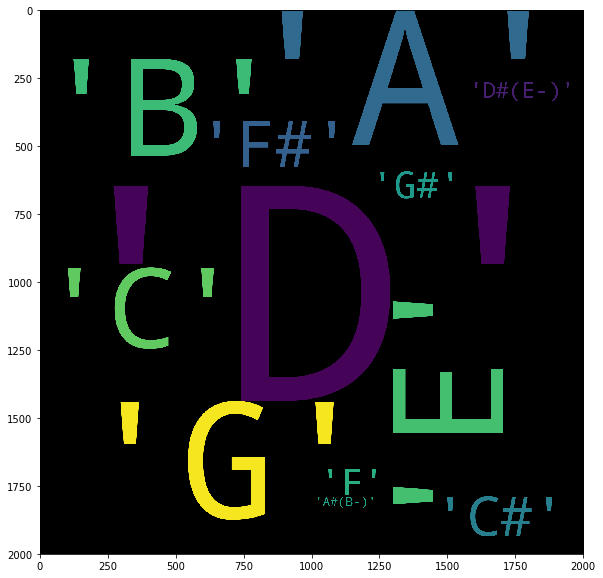

In [126]:
## chord frequency
a = n_gram(sleeping_key,1)
plot_wordcloud(a,50)

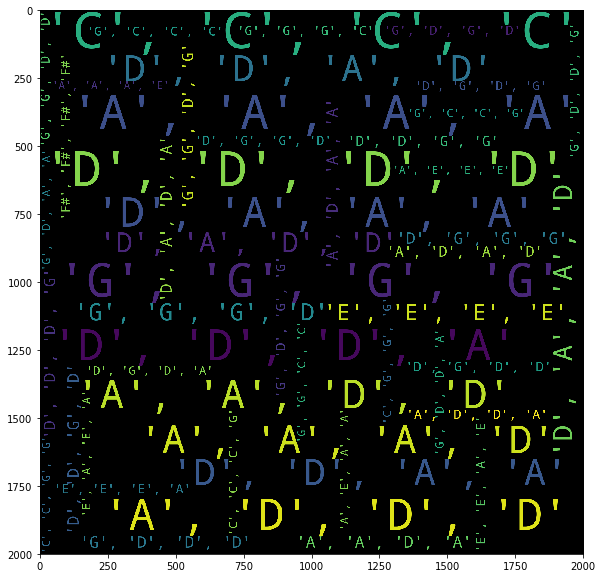

In [127]:
a = n_gram(sleeping_key,4)
plot_wordcloud(a,50)

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

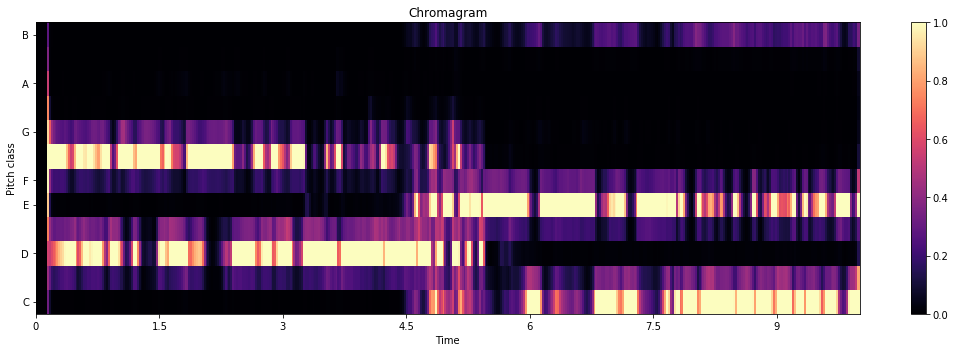

In [433]:

# y,sr = librosa.load('./music/sleeping/'+ sleeping_music[9], duration = 10)   
# b = librosa.feature.chroma_stft(y=y, sr=sr,  n_fft=2048, hop_length=512)
# plt.figure(figsize=(15, 5))
# librosa.display.specshow(b, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('Chromagram')
# plt.tight_layout()

In [434]:
sleeping_music[9]

'm18.wav'

In [447]:
y, sr = librosa.load('./music/sleeping/m1.wav', duration=80)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)


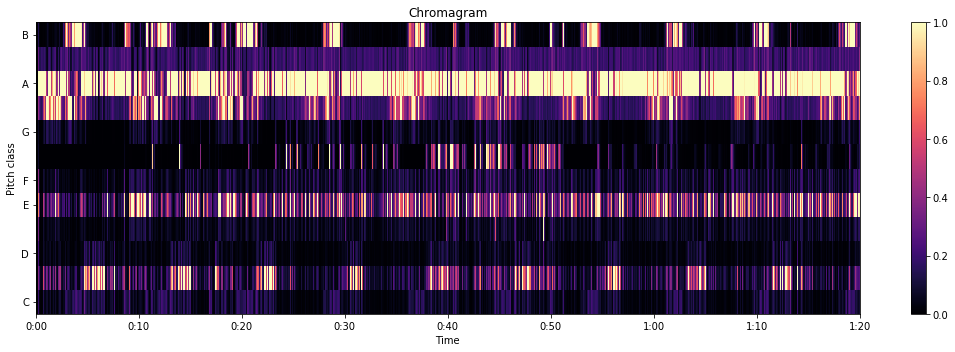

In [448]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)


In [170]:
# def n_gram(key_list, ngram):
#     k_list = [[word for word in line.split(",")] for line in key_list]
#     flattened = [val for sublist in k_list for val in sublist]
#     ngram_key = []
#     for i in range(int(len(flattened)/ngram)):
#         ngram_key.append(flattened[ngram*i : ngram*(i+1)])
#     count_ary = [[x,ngram_key.count(x)] for x in (ngram_key)]
#     unique = []
#     for item in count_ary:
#         if item not in unique:
#             unique.append(item)
#     unique = sorted(unique, key=lambda x:x[1], reverse = True)
#     return unique